In [1]:
import numpy as np
import pandas as pd

item_categories = pd.read_csv('data\item_categories.csv')
items = pd.read_csv('data\items.csv')
sales_train = pd.read_csv('data\sales_train.csv')
shops = pd.read_csv('data\shops.csv')
print('sales_train',sales_train.info())
print('')
print('item_categories',item_categories.info())
print('')
print('items',items.info())
print('')
print('shops',shops.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
sales_train None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
item_categories None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ite

In [2]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [3]:
sales_train['date'] = sales_train['date'].map(lambda row: row.replace('.',''))
sales_train['date'] = pd.to_datetime(sales_train['date'], format = '%d%m%Y')
sales_train = sales_train.set_index('date')
sales_train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-01-02,0,59,22154,999.00,1.0
2013-01-03,0,25,2552,899.00,1.0
2013-01-05,0,25,2552,899.00,-1.0
2013-01-06,0,25,2554,1709.05,1.0
2013-01-15,0,25,2555,1099.00,1.0


<AxesSubplot:xlabel='date'>

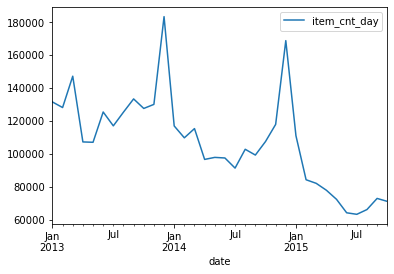

In [4]:
sales_train[['item_cnt_day']].groupby(pd.Grouper(freq='M')).sum().plot(kind='line') # grouby date_block_num is the same

There are over 22,000 items available in 60 shops. Item listings are not the same across all the shops. Hence, we'll aggregate sales based on item id not store id.

In [5]:
df = sales_train[['date_block_num','item_id','item_cnt_day']].groupby(['date_block_num','item_id']).sum()
df = df.rename(columns={'item_cnt_day':'monthly_sales'})
df

monthly_sales
date_block_num item_id               
0              19                 1.0
               27                 7.0
               28                 8.0
               29                 4.0
               32               299.0
...                               ...
33             22162             10.0
               22163             26.0
               22164             15.0
               22166             11.0
               22167             37.0

[233912 rows x 1 columns]

In [6]:
df2 = df.reset_index()
df2

,date_block_num,item_id,monthly_sales
0,0,19,1.0
1,0,27,7.0
2,0,28,8.0
3,0,29,4.0
4,0,32,299.0
...,...,...,...
233907,33,22162,10.0
233908,33,22163,26.0
233909,33,22164,15.0
233910,33,22166,11.0


### Data imputation
Lets make each month have equal number of item listings, zeros for item items with no sales

In [7]:
item_id = df2.item_id.unique()
date_block_num = df2.date_block_num.unique()
multi_index = pd.MultiIndex.from_product([date_block_num,item_id], names=['date_block_num', 'item_id'])
df_impute = df.reindex(multi_index)
df_impute

monthly_sales
date_block_num item_id               
0              19                 1.0
               27                 7.0
               28                 8.0
               29                 4.0
               32               299.0
...                               ...
33             21973             11.0
               22004             44.0
               22005             30.0
               22006             30.0
               22158              1.0

[741438 rows x 1 columns]

In [8]:
df_impute.describe()

,monthly_sales
count,233912.000000
mean,15.596489
std,96.125890
min,-22.000000
25%,2.000000
50%,4.000000
75%,11.000000
max,12557.000000


Check for and replace NANs with zeros

In [9]:
df_impute.isnull().sum()

monthly_sales    507526
dtype: int64

In [10]:
df_impute = df_impute.fillna(0)
df_impute = df_impute.reset_index()
df_impute = df_impute.rename(columns={'date_block_num':'month'})
df_impute.isnull().sum()

month            0
item_id          0
monthly_sales    0
dtype: int64

## Modelling
We'll start by using the monthly sales for one item across (id_num 32) the entire 34 months

In [11]:
id_num = 32    # this item has sales for all months
df_test = df_impute[df_impute.item_id==id_num]
df_test.head()

,month,item_id,monthly_sales
4,0,32,299.0
21811,1,32,208.0
43618,2,32,178.0
65425,3,32,97.0
87232,4,32,66.0


Let's preview data

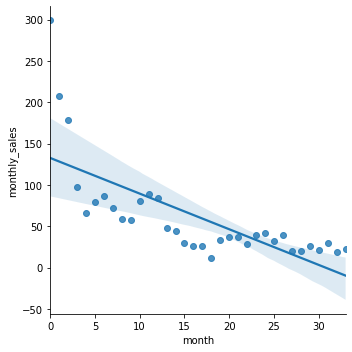

In [15]:
import seaborn as sns

sns.lmplot(x = 'month', y='monthly_sales', data = df_test)

Already, we see on the plot what a linear regression would look like. Let's start off with a linear model

In [16]:
# the only input to our model is the monthly sales data
y = df_test.monthly_sales.values
y = y.reshape(-1,1)
l = len(y)
x = np.arange(l)
x = x.reshape(-1,1)
split = 0.9
x_train = x[:int(l*split)]
x_test = x[int(l*split):]
y_train = y[:int(l*split)]
y_test = y[int(l*split):]

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

xgr = XGBRegressor()
lr = LinearRegression()

#### Train a linear and an XGBoost model

In [18]:
model1 = lr.fit(x_train,y_train)
model2 = xgr.fit(x_train,y_train)
print(model1.score(x_test,y_test), model2.score(x_test,y_test))

-107.83740013786826 -0.5140352826567582


Let's make predictions and visualize

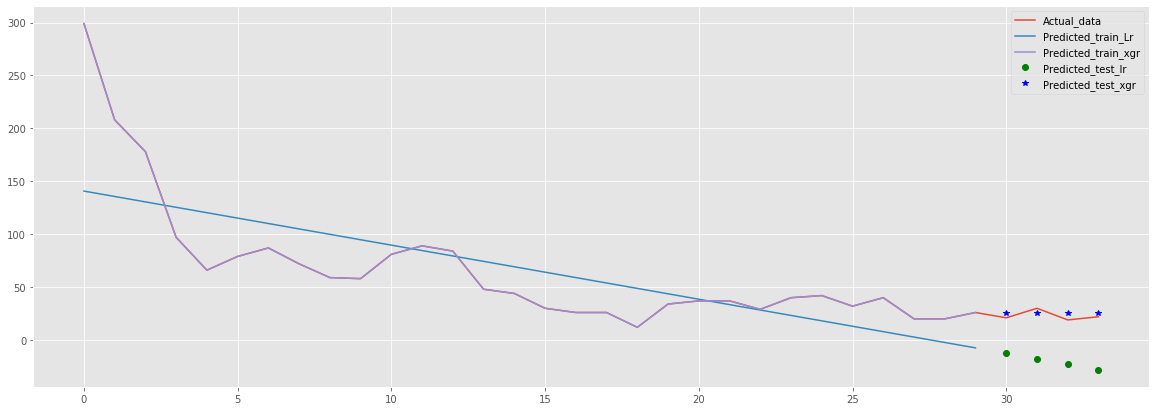

In [16]:
import matplotlib.pyplot as plt

train_predict1 = model1.predict(x_train)
test_predict1 = model1.predict(x_test)

train_predict2 = model2.predict(x_train)
test_predict2 = model2.predict(x_test)

plt.style.use('ggplot')
plt.figure(figsize=(20, 7)) 
plt.plot(y.ravel(), label="Actual_data")
plt.plot(train_predict1.ravel(), label="Predicted_train_Lr")
plt.plot(train_predict2.ravel(), label="Predicted_train_xgr")

l1 = len(x_train)
m1 = len(x_test)
x_plot = np.array([l1+i for i in range(m1)])
plt.plot(x_plot,test_predict1, 'go', label='Predicted_test_lr')
plt.plot(x_plot,test_predict2, 'b*', label='Predicted_test_xgr')
plt.legend()
plt.show()

In this case, the XGR model appears to perfectly fit the training data and generalizes fairly well on the test data. The linear model on the other hand isn't a good fit.

Let's now remove the __outliers__ in the data and train again the two models

In [19]:
def outlier_removal(df,col):
    q3 = df[col].quantile(0.75)
    q1 = df[col].quantile(0.25)
    col_ub = q3 + 1.5*(q3-q1)      # upper bound
    col_lb = q1 - 1.5*(q3-q1)     # lower bound
    df_new = df[df[col] <= col_ub]
    df_new2 = df_new[df_new[col] >= col_lb]
    return df_new2

df_test2 = outlier_removal(df_test,'monthly_sales')
print('removed outliers: ',df_test.shape[0]-df_test2.shape[0])

removed outliers:  3


In [18]:
# the only input to our model is the monthly sales data
y2 = df_test2.monthly_sales.values
y2 = y2.reshape(-1,1)
l2 = len(y2)
x2 = np.arange(l2)
x2 = x2.reshape(-1,1)
x_train = x2[:int(l2*split)]
x_test = x2[int(l2*split):]
y_train = y2[:int(l2*split)]
y_test = y2[int(l2*split):]

In [19]:
model1 = lr.fit(x_train,y_train)
model2 = xgr.fit(x_train,y_train)
print(model1.score(x_test,y_test), model2.score(x_test,y_test))

-9.758863705221057 -0.5139509473528181


Let's make predictions and visualize again

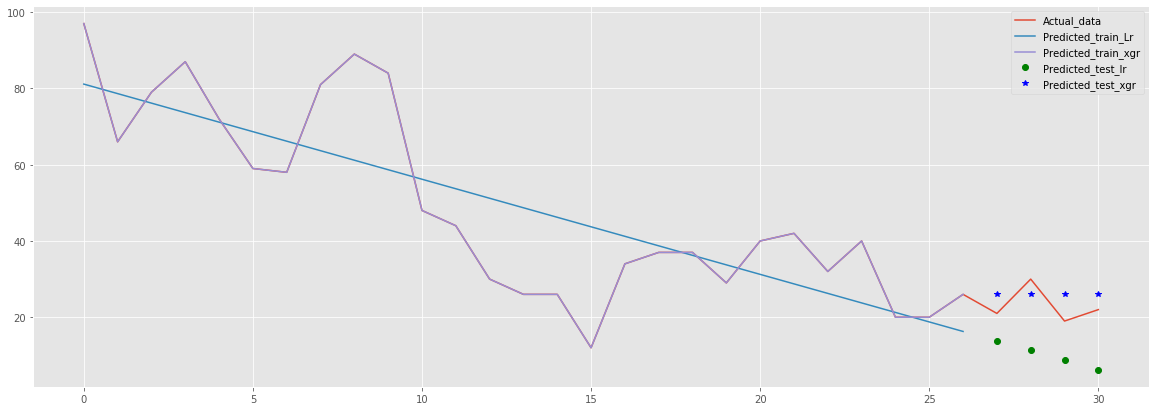

In [20]:
train_predict1 = model1.predict(x_train)
test_predict1 = model1.predict(x_test)

train_predict2 = model2.predict(x_train)
test_predict2 = model2.predict(x_test)

plt.style.use('ggplot')
plt.figure(figsize=(20, 7)) 
plt.plot(y2.ravel(), label="Actual_data")
plt.plot(train_predict1.ravel(), label="Predicted_train_Lr")
plt.plot(train_predict2.ravel(), label="Predicted_train_xgr")

l1 = len(x_train)
m1 = len(x_test)
x_plot = np.array([l1+i for i in range(m1)])
plt.plot(x_plot,test_predict1, 'go', label='Predicted_test_lr')
plt.plot(x_plot,test_predict2, 'b*', label='Predicted_test_xgr')
plt.legend()
plt.show()

Not much improvement in either model. Also, XGR predictions are essentially the same for the 4 test months

### ARIMA Model
AutoRegressive Integrated Moving Average

In [21]:
from statsmodels.tsa.arima_model import ARIMA

In [76]:
# set period P = 5, difference d = 1, moving average q = 0
model = ARIMA(y_train, order=(5,1,1))
model_fit = model.fit()
predict = model_fit.predict(start=x_plot[0],end=x_plot[-1],typ='levels',dynamic=True)

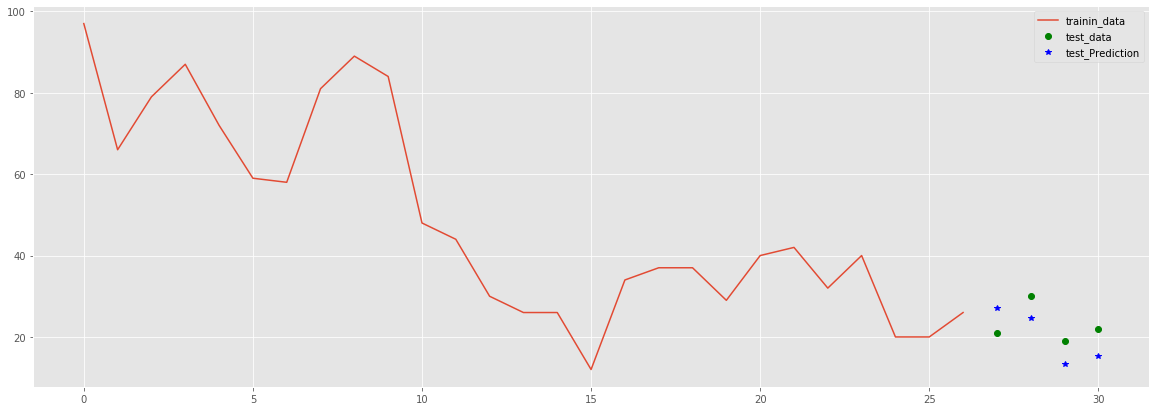

In [77]:
plt.style.use('ggplot')
plt.figure(figsize=(20, 7)) 
plt.plot(y_train.ravel(), label="trainin_data")
plt.plot(x_plot,y_test, 'go', label='test_data')
plt.plot(x_plot,predict, 'b*', label='test_Prediction')
plt.legend()
plt.show()

In [50]:
model_fit.forecast()

(array([15.03500259]),
 array([21.24797905]),
 array([[-26.61027109,  56.68027627]]))

### Prophet

The input to Prophet is always a dataframe with two columns: **ds** and **y**. The **ds** (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The **y** column must be numeric, and represents the measurement we wish to forecast.

In [83]:
from fbprophet import Prophet

#Extract y and ds from sales data. remove outliers and train
#for_prophet = sales_train[['item_cnt_day']].groupby(pd.Grouper(freq='M')).sum().reset_index()
for_prophet = sales_train[sales_train.item_id==32][['item_cnt_day']].groupby(pd.Grouper(freq='M')).sum().reset_index()
for_prophet.rename(columns={'item_cnt_day':'y','date':'ds'},inplace=True)

m = Prophet()
m.fit(for_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


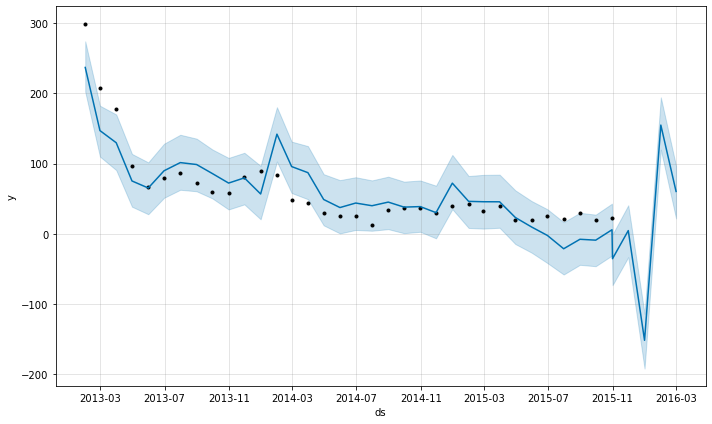

In [84]:
future = m.make_future_dataframe(periods=5,freq='MS')
forecast = m.predict(future)
fig1 = m.plot(forecast)

### Lets try LSTM

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Reshape, RNN, LSTM)
from tensorflow.keras.optimizers import Adam

Lets define a function that reshapes our 1D array input into the appropriate shape for the LSTM model

In [22]:
def lstm_data_transform(x_data, y_data, num_steps):
    """ Changes data to the format for LSTM training 
    for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

Next, we create a function then generates training and test data for our LSTM model

In [23]:
def create_LSTM_train_test_data(df_all_item,item_num,time_steps):
    df_test = df_all_item[df_all_item.item_id==item_num]
    y = df_test.monthly_sales.values
    y = y.reshape(-1,1)
    l = len(y)
    x_new,y_new = lstm_data_transform(y, y, time_steps)
    splt_idx = int(x_new.shape[0]*0.9)
    x_train = tf.cast(x_new[:splt_idx],tf.float32)
    x_test = tf.cast(x_new[splt_idx:], tf.float32)
    y_train = tf.cast(y_new[:splt_idx], tf.float32)
    y_test = tf.cast(y_new[splt_idx:], tf.float32)
    return x_train,y_train,x_test,y_test
    

Create a function that defines and train an LSTM model

In [24]:
def LSTM_trainer(x_train,y_train):
    model = Sequential()

    #model.add(Reshape(target_shape= [time_step,1]))
    model.add(LSTM(60,  input_shape=(time_steps, 1),
                   activation='tanh',
                   return_sequences=False))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=1, activation='linear',
                   #kernel_regularizer=tf.keras.regularizers.l1(l=0.4)
                   ))

    model.compile(optimizer=Adam(lr=0.01),
                  loss='mse',
                  #metrics=['accuracy']
                 )
    model.fit(x=x_train, y=y_train, epochs=500, verbose=0)
    return model

Create a function that plots train and test predictions

In [25]:
def plot_predictions(model,x_train,y_train,x_test,y_test):
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)

    l = len(x_train)
    m = len(x_test)
    x_plot = np.array([l+i for i in range(m)])
    
    plt.style.use('ggplot')
    plt.figure(figsize=(20, 7)) 
    
    plt.plot(y_train, '*-',label="Actual train")
    plt.plot(train_predict, '*-',label="Predicted train")
    
    plt.plot(x_plot,y_test, 'b.-', label='Acutal test')
    plt.plot(x_plot,test_predict, 'g.-', label='Predicted test')
    
    plt.xlabel('Months')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

#### Let's now train our LSTM and make predictions

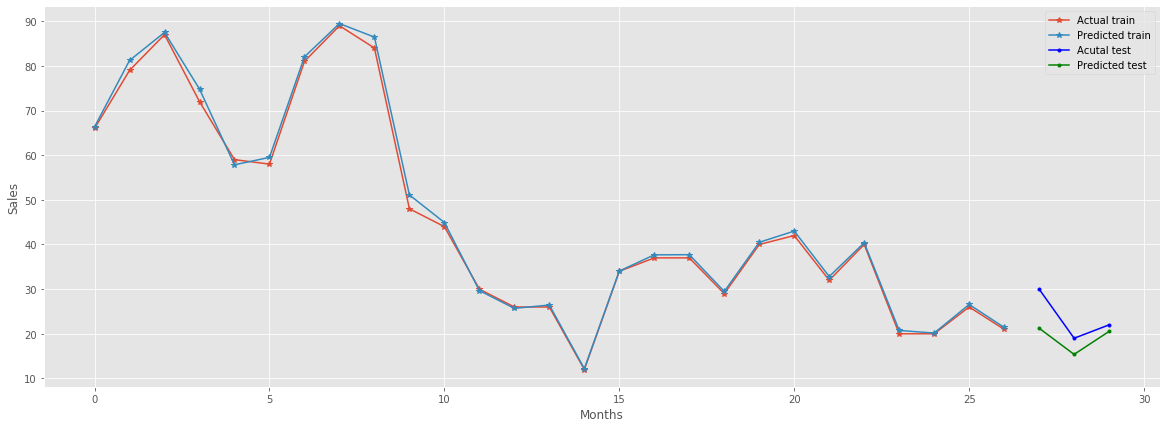

In [35]:
time_steps = 4
item_num = 32

x_train,y_train,x_test,y_test = create_LSTM_train_test_data(df_impute,item_num,time_steps)

model = LSTM_trainer(x_train,y_train)

plot_predictions(model,x_train,y_train,x_test,y_test)

### Predict next month sales

To predict sales for next month, we use sales data for last __*time_steps*__ months.

In [28]:
def next_month_sales(model,y,time_steps):
    x_input = y[-time_steps:].reshape((1,time_steps,1))
    sales = model.predict(x_input)
    return sales.ravel()
next_month_sales(model,y,time_steps)

array([21.544228], dtype=float32)

In [36]:
item_id

array([   19,    27,    28, ..., 22005, 22006, 22158], dtype=int64)

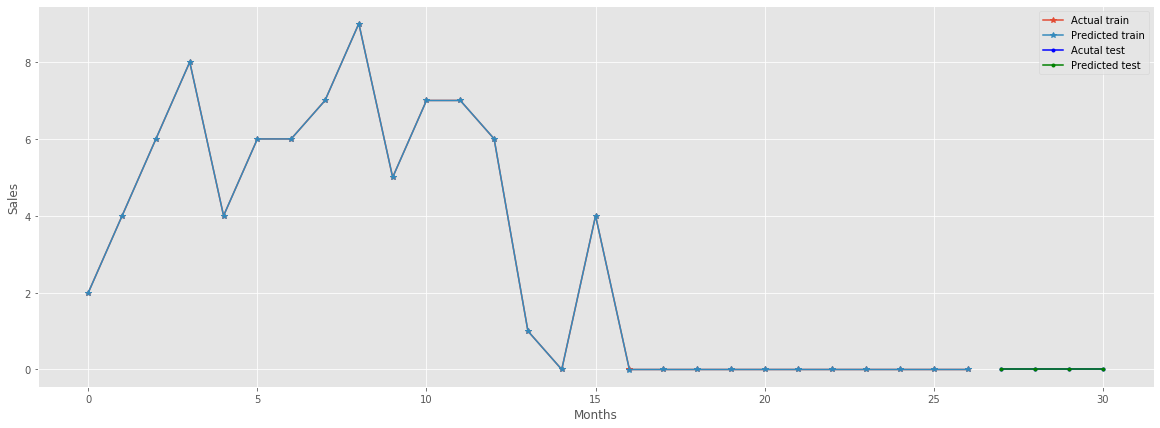

In [39]:
time_steps = 3
item_num = 55

x_train,y_train,x_test,y_test = create_LSTM_train_test_data(df_impute,item_num,time_steps)

model = LSTM_trainer(x_train,y_train)

plot_predictions(model,x_train,y_train,x_test,y_test)